<a href="https://www.kaggle.com/code/andreynesterov/commonlit-ess-debertav3?scriptVersionId=145606389" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center>
<div style="color:;
           display:fill;
           border-radius:5px;
           background-color: lightgray;
           font-size:110%;
           letter-spacing:0.5px">

<h2 style="padding: 10px;
              color:white;">Evaluate Student Summaries
</h2>
</div>

1. [Introduction](#introduction)
1. [Data Collection](#datacollection)
1. [Data Analysis](#dataanalysis)
1. [Data Preprocessing](#datapreprocessing)
1. [Model Training and Evaluation](#trainandevaluate)
1. [Submission](#submission)

# Introduction <a class="anchor" id="introduction"></a>

The goal of this competition is to assess the quality of summaries written by students in grades 3-12. Simply training a model on the entire dataset leads to overfitting. To avoid this problem, the Out of Fold (OOF) approach is used. The NLP model chosen is Deberta-v3-Base. Trained OOF models can also be used for extracting embeddings (see e.g.: [CommonLit - Extracting Embeddings](http://https://www.kaggle.com/code/javigallego/commonlit-extracting-embeddings/notebook)) and further regressor training.

This notebook covers:
1. Exploratory Data Analysis (simple)
1. Wandb tracking
1. Cleaning and text processing
1. Sentence encoding using tokenization and embeddings
1. Out of Fold (OOF) approach
1. Training and evaluation Deberta model
1. Stacking results

## Dependencies

In [1]:
import os
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
IN_COLAB = os.getenv("COLAB_RELEASE_TAG") is not None
ON_AWS = os.getenv("CONDA_DEFAULT_ENV") is not None
WANDB_ENABLE = False

In [2]:
if ON_KAGGLE:
    !pip install --no-index --find-links=/kaggle/input/pyspellchecker pyspellchecker
else:
    !pip install pyspellchecker

Looking in links: /kaggle/input/pyspellchecker
Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [3]:
if ON_KAGGLE:
    !pip install --no-index --find-links=/kaggle/input/autocorrect-110 autocorrect
else:
    !pip install autocorrect==1.1.0

Looking in links: /kaggle/input/autocorrect-110
Processing /kaggle/input/autocorrect-110/autocorrect-1.1.0-py3-none-any.whl


In [4]:
if ON_KAGGLE:
    !pip install --no-index --find-links=/kaggle/input/contractions-source contractions
else:
    !pip install contractions

Looking in links: /kaggle/input/contractions-source
Processing /kaggle/input/contractions-source/contractions-0.1.73-py2.py3-none-any.whl
Processing /kaggle/input/contractions-source/textsearch-0.0.24-py2.py3-none-any.whl (from contractions)
Processing /kaggle/input/contractions-source/anyascii-0.3.2-py3-none-any.whl (from textsearch>=0.0.21->contractions)
Processing /kaggle/input/contractions-source/pyahocorasick-2.0.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (from textsearch>=0.0.21->contractions)


In [5]:
if IN_COLAB:
    !pip install transformers[torch]
    !pip install sentencepiece

In [6]:
import gc
import re
import math
import time
import glob
import random
import shutil
import string
import warnings
from typing import Optional, Tuple, Union, List
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import contractions
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import DebertaV2Model, DebertaV2PreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from typing import Optional, Tuple, Union
        
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=42)
tqdm.pandas()

In [7]:
if not ON_KAGGLE:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')

In [8]:
if IN_COLAB:
    from google.colab import drive
    from google.colab import auth
    from googleapiclient.discovery import build

    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Kaggle/commonlit-evaluate-student-summaries
    auth.authenticate_user() # needed to empty trash while training

In [9]:
if WANDB_ENABLE:
    !pip install wandb
    import wandb
    # paste API key below from your wandb profile
    !wandb login

# Data Collection <a class="anchor" id="datacollection"></a>

In [10]:
competition = 'commonlit-evaluate-student-summaries'
summaries_train = "summaries_train.csv"
prompts_train = "prompts_train.csv"
summaries_test = "summaries_test.csv"
prompts_test = "prompts_test.csv"
sample_submission = "sample_submission.csv"
    
if ON_KAGGLE:
    root_path = f"/kaggle/input/{competition}/"
if IN_COLAB:
    root_path = ""
if ON_AWS:
    root_path = f"/home/studio-lab-user/sagemaker-studiolab-notebooks/data/{competition}/"

summaries_train = f"{root_path}{summaries_train}"
prompts_train = f"{root_path}{prompts_train}"
summaries_test = f"{root_path}{summaries_test}"
prompts_test = f"{root_path}{prompts_test}"
sample_submission = f"{root_path}{sample_submission}"

In [11]:
summaries_train_df = pd.read_csv(summaries_train)
prompts_train_df = pd.read_csv(prompts_train)
sample_submission_df = pd.read_csv(sample_submission)
summaries_test_df = pd.read_csv(summaries_test)
prompts_test_df = pd.read_csv(prompts_test)

# Data Analysis <a class="anchor" id="dataanalysis"></a>

## Explore Dataset <a class="anchor" id="exploredataset"></a>

Explore basic information about the dataset.

In [12]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [13]:
prompts_train_df.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [14]:
summaries_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


In [15]:
prompts_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


In [16]:
summaries_train_df["prompt_id"].value_counts()

prompt_id
39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: count, dtype: int64

In [17]:
merged_df = summaries_train_df.merge(prompts_train_df, how="left", on="prompt_id")
merged_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


Determine the maximum length of the input sequence.

In [18]:
def join_columns(row, col_names, separator):
    values = [str(row[col]) for col in col_names]
    return separator.join(values)

def join_df_columns(df, columns_to_join, separator):
    joined_text = df.apply(join_columns, axis=1, args=(columns_to_join, separator)).to_numpy()
    return joined_text

def get_tokenizer_max_len(data, tokenizer):
    token_lens = []
    for txt in data:
        tokens = tokenizer.encode(txt, max_length=4096, truncation=True)
        token_lens.append(len(tokens))
    max_length = np.max(token_lens)
    return max_length

In [19]:
train_text_cols = ["prompt_question", "text"]
load_path = "/kaggle/input/debertav3base" if ON_KAGGLE else "microsoft/deberta-v3-base"
tokenizer_0 = AutoTokenizer.from_pretrained(load_path)
separator = " " + tokenizer_0.sep_token + " "
train_texts = join_df_columns(merged_df, train_text_cols, separator)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
MAX_LEN = get_tokenizer_max_len(train_texts, tokenizer_0)
print("Maximum length (train text): ", MAX_LEN)

Maximum length (train text):  854


In [21]:
def plot_scores_density(df, attributes=[]):
    num_attr = len(attributes)
    bins = 15
    fig, axes = plt.subplots(num_attr, 3, figsize=(7*num_attr, 7))
    count = 0
    for attr, ax in zip(attributes, axes):
        sns.histplot(data=df, x=attr, kde=True, common_norm=False, bins=bins,
                     ax=ax[0], hue="prompt_id", multiple='dodge')
        ax[0].set(xlabel=attr)
        sns.boxplot(data=df.reset_index(drop=True), y=attr, ax=ax[1])
        ax[1].set(xlabel=attr)
        sns.violinplot(data=df.reset_index(drop=True), y=attr, ax=ax[2])
        ax[2].set(xlabel=attr)
        if count == 0:
            ax[0].set_title(f'Density')
            ax[1].set_title(f'Distribution')
            ax[1].set_title(f'Distribution')
        count += 1
    plt.show()

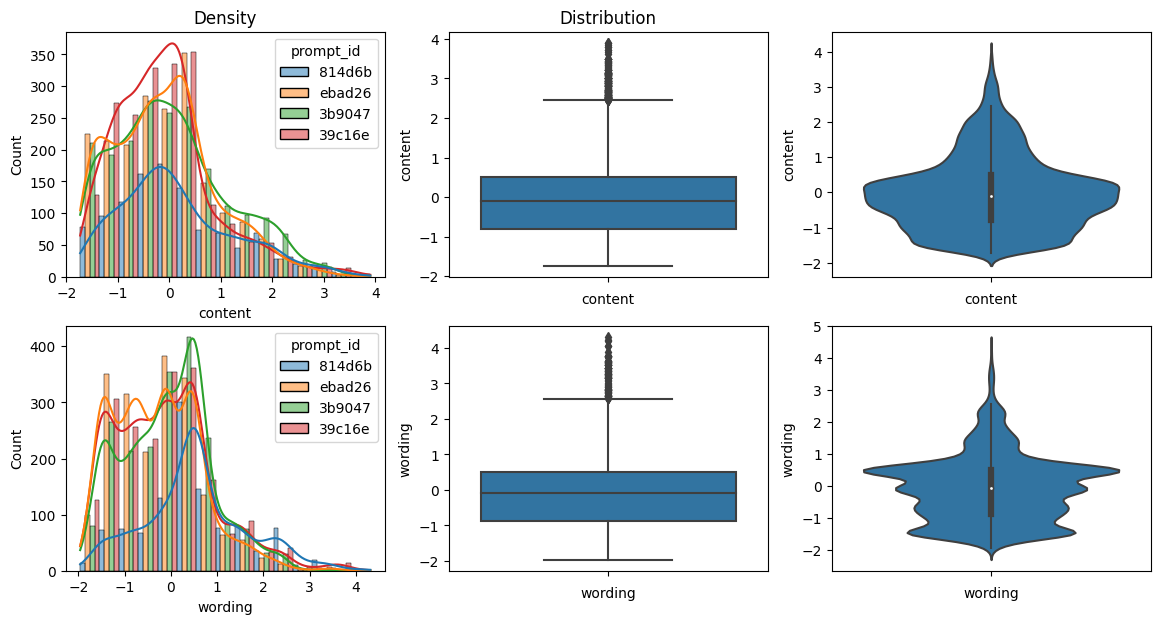

In [22]:
plot_scores_density(summaries_train_df, ['content', 'wording'])

## Correlation analysis

Check the correlation between the 'content' and 'wording' scores.

In [23]:
corr_matrix_abs = summaries_train_df[['content', 'wording']].corr().abs()
corr_matrix_abs

,content,wording
content,1.00000,0.75138
wording,0.75138,1.00000


# Data Preprocessing <a class="anchor" id="datapreprocessing"></a>

In [24]:
class Preprocessor:
    def __init__(self, stop_words=set(stopwords.words('english'))) -> None:
        self.stop_words = stop_words
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker()

    def clean_text(self, text: str) -> str:
        text = re.sub(re.compile(r'[\n\r\t]'), ' ', text)
        text = re.sub(r'\.([A-Za-z])', r'. \1', text)
        text = re.sub(r'\,(\w)', r', \1', text)
        text = re.sub(r'\-', ' ', text)
        text = re.sub(r'\/', ' ', text)
        text = re.sub(r'\¨', '"', text)
        text = re.sub(r'\” ', '" ', text)
        text = re.sub(r'\“', '"', text)
        text = re.sub(r"\\'s ", "\'s", text)
        text = re.sub(r"\'t", "'t", text)
        text = re.sub(r"\s{2,}", " ", text)
        text = re.sub(r"^\s+", "", text)
        text = re.sub(r"\s+$", "", text)
        return text
    
    def word_overlap_count(self, row):
        def check_is_stop_word(word):
            return word in self.stop_words
            
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.stop_words:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))

    def ngrams(self, token, n):
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int) -> int:
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))
        common_ngrams = original_ngrams.intersection(summary_ngrams)
        return len(common_ngrams)

    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text):
        wordlist = self.spellchecker.split_words(text)
        amount_miss = len(list(self.spellchecker.unknown(wordlist)))
        return amount_miss

    def add_spelling_dictionary(self, tokens: List[str]) -> List[str]:
        self.spellchecker.word_frequency.load_words(tokens)
        self.speller.nlp_data.update({token:1000 for token in tokens})

    def run(self,
            prompts: pd.DataFrame,
            summaries:pd.DataFrame
        ) -> pd.DataFrame:

        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        summaries["text"] = summaries["text"].progress_apply(
            lambda x: self.clean_text(x))
        
        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )

        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )

        # fix misspelling
        # summaries["fixed_summary_text"] = summaries["text"].progress_apply(
        #     lambda x: self.speller(x.lower())
        # )

        # count misspelling
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)

        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']

        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1
        )
        input_df['bigram_overlap_ratio'] = input_df['bigram_overlap_count'] / (input_df['summary_length'] - 1)

        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        input_df['trigram_overlap_ratio'] = input_df['trigram_overlap_count'] / (input_df['summary_length'] - 2)

        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)

        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])

In [25]:
def add_fold_field(df, group_field="prompt_id") -> pd.DataFrame:
    gkf = GroupKFold(n_splits=4)
    for i, (_, val_index) in enumerate(gkf.split(df, groups=df[group_field])):
        df.loc[val_index, "fold"] = i
    return df

In [26]:
%%time
preprocessor = Preprocessor(stop_words=ENGLISH_STOP_WORDS)
train_df = preprocessor.run(prompts_train_df, summaries_train_df)

100%|██████████| 7165/7165 [00:00<00:00, 91247.24it/s]

CPU times: user 13.6 s, sys: 134 ms, total: 13.8 s
Wall time: 13.9 s


In [27]:
%%time
test_df = preprocessor.run(prompts_test_df, summaries_test_df)

100%|██████████| 4/4 [00:00<00:00, 4218.56it/s]

CPU times: user 74.8 ms, sys: 5.97 ms, total: 80.7 ms
Wall time: 79.7 ms


In [28]:
train_df = add_fold_field(train_df)

In [29]:
train_df.head()

,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,fold
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,2,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.096970,15,4,0.063492,0,0.000000,0,3.0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,0,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1076,0.050186,20,22,0.415094,10,0.192308,0,2.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,272,0,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.435200,28,54,0.199262,25,0.092593,2,1.0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,32,2,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.051200,6,8,0.258065,5,0.166667,0,1.0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the s...,3.272894,3.219757,232,11,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.351515,26,27,0.116883,5,0.021739,4,3.0


In [30]:
train_df.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'summary_length', 'splling_err_num', 'prompt_question', 'prompt_title',
       'prompt_text', 'prompt_length', 'length_ratio', 'word_overlap_count',
       'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_count',
       'trigram_overlap_ratio', 'quotes_count', 'fold'],
      dtype='object')

### Datasets

In [31]:
class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, text_fields, target_fields):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.target_values = df[target_fields].values
        self.text_values = df[text_fields].values
        self.sep_token = " " + self.tokenizer.sep_token + " "
        self.bos_token = self.tokenizer.bos_token + " "

    def __len__(self):
        return len(self.target_values)

    def __getitem__(self , index):
        row_text_values = self.text_values[index]
        full_text = self.sep_token.join(map(str, row_text_values))
        tokenized = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_len,
            padding=False
        )
        ids = tokenized['input_ids']
        mask = tokenized['attention_mask']
        type_ids = tokenized['token_type_ids']
        target = self.target_values[index]
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(type_ids, dtype=torch.long),
            'labels': torch.tensor(target, dtype=torch.float32)
        }


class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, text_fields):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_values = df[text_fields].values
        self.sep_token = " " + self.tokenizer.sep_token + " "

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row_text_values = self.text_values[index]
        full_text = self.sep_token.join(map(str, row_text_values))
        tokenized = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_len,
            padding=False
        )
        return tokenized

In [32]:
def prepare_ds_by_fold(df, tokenizer, fold, max_len, text_fields, target_fields):
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]
    train_ds = TrainDataset(
        train_df,
        tokenizer=tokenizer,
        max_len=max_len,
        text_fields=text_fields,
        target_fields=target_fields
    )
    val_ds = TrainDataset(
        val_df,
        tokenizer=tokenizer,
        max_len=max_len,
        text_fields=text_fields,
        target_fields=target_fields
    )
    return train_ds, val_ds

# Model Training and Evaluation <a class="anchor" id="trainandevaluate"></a>

In [33]:
def compute_mcrmse(eval_pred):
    preds, labels = eval_pred
    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)
    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

### Configuration

In [34]:
class CFG:
    load_path="/kaggle/input/debertav3base"
    output_dir="models/debertav3base"
    model_type_attr="deberta"
    model_type_subattr="encoder"
    model_emb_attr="embeddings"
    learning_rate=2e-5
    ratio_layers_to_freeze=0.5
    freeze_embeddings=True
    warmup_ratio=0
    weight_decay=0.03
    batch_size=4
    eval_batch_size=8
    auto_find_batch_size=True
    gradient_accumulation_steps=2
    num_train_epochs=3
    text_fields=["prompt_question", "text"]
    target_fields=['content', 'wording']
    fp16=False
    max_grad_norm=0.3
    lr_scheduler_type='cosine'
    attention_probs_dropout_prob=0.007
    hidden_dropout_prob=0.007
    num_labels=2
    n_splits=4
    random_seed=42
    save_steps=100
    max_length=860 #MAX_LEN
    ignore_mismatched_sizes=False
    metric_for_best_model="mcrmse"
    compute_metrics_fn=compute_mcrmse
    model_class=AutoModelForSequenceClassification
    report_to='none'
    wandb_project="CommonLit_Summaries"
    run_name="debertav3base-maxlen"

if WANDB_ENABLE:
    CFG.report_to='wandb'
    os.environ["WANDB_PROJECT"] = CFG.wandb_project

In [35]:
CFG.load_path = "/kaggle/input/debertav3base" if ON_KAGGLE else "microsoft/deberta-v3-base"

Check the model structure.

In [36]:
model_config = AutoConfig.from_pretrained(CFG.load_path, output_hidden_states=False)
model_config.update({
    "hidden_dropout_prob": CFG.hidden_dropout_prob,
    "attention_probs_dropout_prob": CFG.attention_probs_dropout_prob,
    "num_labels": CFG.num_labels,
    "problem_type": "regression",
})
model_check = CFG.model_class.from_pretrained(CFG.load_path, config=model_config)
model_check

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [37]:
named_params = len(list(model_check.named_parameters()))
print(f"Model named params count: {named_params}")

Model named params count: 202


Define functions for training

In [38]:
# for google colab
class ClearDriveTrash(transformers.TrainerCallback):
    @staticmethod
    def _clear_drive_trash(self):
        drive_service = build('drive', 'v3')
        drive_service.files().emptyTrash().execute()
        
    def on_save(self, args, state, control, **kwargs):
        ClearDriveTrash._clear_drive_trash()

In [39]:
def prepare_trainer(model, train_ds, val_ds, tokenizer, output_dir, cfg):
    data_collator = DataCollatorWithPadding(tokenizer)
    if IN_COLAB:
        clear_drive_trash_cb = ClearDriveTrash()
        callbacks=[clear_drive_trash_cb]
    else:
        callbacks=[]
    trainer_args = TrainingArguments(
        output_dir=output_dir,
        load_best_model_at_end=True,
        learning_rate=cfg.learning_rate,
        warmup_ratio=cfg.warmup_ratio,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.eval_batch_size,
        gradient_accumulation_steps=cfg.gradient_accumulation_steps,
        num_train_epochs=cfg.num_train_epochs,
        weight_decay=cfg.weight_decay,
        eval_steps=cfg.save_steps,
        save_steps=cfg.save_steps,
        auto_find_batch_size=cfg.auto_find_batch_size,
        fp16=cfg.fp16,
        lr_scheduler_type=cfg.lr_scheduler_type,
        max_grad_norm=cfg.max_grad_norm,
        metric_for_best_model=cfg.metric_for_best_model,
        report_to=cfg.report_to,
        run_name=cfg.run_name,
        disable_tqdm=True,
        greater_is_better=False,
        save_strategy="steps",
        evaluation_strategy="steps",
        save_total_limit=1,
    )
    model_trainer = Trainer(
        model=model,
        args=trainer_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=cfg.compute_metrics_fn,
        data_collator=data_collator,
        callbacks=callbacks,
    )
    return model_trainer

In [40]:
def create_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

In [41]:
def remove_checkpoints(path):
    checkpoint_folders = glob.glob(f'{path}/checkpoint-*')
    for folder in checkpoint_folders:
        shutil.rmtree(folder)

In [42]:
def model_layers_freeze(model, cfg):
    model_attr1 = getattr(model, cfg.model_type_attr)
    if cfg.freeze_embeddings:
        model_emb_attr =  getattr(model_attr1, cfg.model_emb_attr)
        model_emb_attr.requires_grad_(False)
    if cfg.ratio_layers_to_freeze > 0:
        model_attr2 = getattr(model_attr1, cfg.model_type_subattr)
        layers_count = len(model_attr2.layer)
        layers_count_to_freeze = int(layers_count * cfg.ratio_layers_to_freeze)
        for i in range(layers_count_to_freeze):
            for n, p in model_attr2.layer[i].named_parameters():
                p.requires_grad = False

In [43]:
def create_train_model(cfg):
    model_config = AutoConfig.from_pretrained(cfg.load_path)
    model_config.update({
        "hidden_dropout_prob": cfg.hidden_dropout_prob,
        "attention_probs_dropout_prob": cfg.attention_probs_dropout_prob,
        "problem_type": "regression",
        "num_labels": cfg.num_labels,
    })
    model = cfg.model_class.from_pretrained(
        cfg.load_path,
        config=model_config,
        ignore_mismatched_sizes=cfg.ignore_mismatched_sizes
    )
    return model

In [44]:
def test_by_fold_models(cfg, df):
    tokenizer = AutoTokenizer.from_pretrained(cfg.load_path)
    test_ds = TestDataset(
        df,
        tokenizer=tokenizer,
        max_len=cfg.max_length,
        text_fields=cfg.text_fields
    )
    data_collator = DataCollatorWithPadding(tokenizer)
    all_preds = []
    for fold in range(CFG.n_splits):
        print(f"Fold_{fold} model")
        model_fold_dir = os.path.join(cfg.output_dir, f"fold_{fold}")
        model_config = AutoConfig.from_pretrained(model_fold_dir)
        model = cfg.model_class.from_pretrained(
            model_fold_dir,
            config=model_config
        )
        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train=False,
            do_predict=True,
            per_device_eval_batch_size=cfg.eval_batch_size,
            dataloader_drop_last=False,
        )
        model_trainer = Trainer(
            model = model,
            tokenizer=tokenizer,
            data_collator=data_collator,
            args = test_args
        )
        test_preds = model_trainer.predict(test_ds)[0]
        all_preds.append(test_preds)
    return all_preds

In [45]:
def train_by_fold(cfg, df):
    evals = []
    create_folder(cfg.output_dir)
    run_name_init = cfg.run_name
    if IN_COLAB:
        ClearDriveTrash._clear_drive_trash()
    for fold in range(cfg.n_splits):
        print(f"Fold: {fold}")
        cfg.run_name = f"{run_name_init}_fold_{fold}"
        output_fold_dir = os.path.join(cfg.output_dir, f"fold_{fold}")
        model = create_train_model(cfg)
        model_layers_freeze(model, cfg)
        tokenizer = AutoTokenizer.from_pretrained(cfg.load_path)
        train_ds, val_ds = prepare_ds_by_fold(
            df=df,
            tokenizer=tokenizer,
            fold=fold,
            max_len=cfg.max_length,
            text_fields=cfg.text_fields,
            target_fields=cfg.target_fields
        )
        trainer = prepare_trainer(
            model=model,
            train_ds=train_ds,
            val_ds=val_ds,
            tokenizer=tokenizer,
            output_dir=output_fold_dir,
            cfg=cfg,
        )
        trainer.train()
        model.save_pretrained(output_fold_dir)
        tokenizer.save_pretrained(output_fold_dir)
        eval_outs = trainer.predict(val_ds)
        evals.append(eval_outs)
        remove_checkpoints(output_fold_dir)
        if WANDB_ENABLE:
            wandb.finish()
            time.sleep(10)
        if IN_COLAB:
            time.sleep(30)
            ClearDriveTrash._clear_drive_trash()
    if IN_COLAB:
        for _ in range(2):
            time.sleep(30)
            ClearDriveTrash._clear_drive_trash()
    return evals

## Training

In [46]:
%%time
eval_results = train_by_fold(CFG, train_df)

Fold: 0


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.41756319999694824, 'eval_content_rmse': 0.547404944896698, 'eval_wording_rmse': 0.7317605018615723, 'eval_mcrmse': 0.6395827531814575, 'eval_runtime': 18.4038, 'eval_samples_per_second': 111.77, 'eval_steps_per_second': 14.019, 'epoch': 0.16}
{'eval_loss': 0.34668394923210144, 'eval_content_rmse': 0.5170198082923889, 'eval_wording_rmse': 0.6527312397956848, 'eval_mcrmse': 0.5848755240440369, 'eval_runtime': 18.2936, 'eval_samples_per_second': 112.444, 'eval_steps_per_second': 14.103, 'epoch': 0.31}
{'eval_loss': 0.2778435945510864, 'eval_content_rmse': 0.45980584621429443, 'eval_wording_rmse': 0.5867417454719543, 'eval_mcrmse': 0.5232738256454468, 'eval_runtime': 18.3929, 'eval_samples_per_second': 111.836, 'eval_steps_per_second': 14.027, 'epoch': 0.47}
{'eval_loss': 0.4051177203655243, 'eval_content_rmse': 0.6176515221595764, 'eval_wording_rmse': 0.6547834873199463, 'eval_mcrmse': 0.636217474937439, 'eval_runtime': 18.397, 'eval_samples_per_second': 111.812, 'eval_ste

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.44425341486930847, 'eval_content_rmse': 0.561100423336029, 'eval_wording_rmse': 0.7574118971824646, 'eval_mcrmse': 0.6592561602592468, 'eval_runtime': 26.6348, 'eval_samples_per_second': 75.428, 'eval_steps_per_second': 9.461, 'epoch': 0.16}
{'eval_loss': 0.4202098250389099, 'eval_content_rmse': 0.5262109637260437, 'eval_wording_rmse': 0.7506812214851379, 'eval_mcrmse': 0.6384460926055908, 'eval_runtime': 26.5776, 'eval_samples_per_second': 75.59, 'eval_steps_per_second': 9.482, 'epoch': 0.31}
{'eval_loss': 0.4262295961380005, 'eval_content_rmse': 0.5475069284439087, 'eval_wording_rmse': 0.7434350848197937, 'eval_mcrmse': 0.6454709768295288, 'eval_runtime': 26.5671, 'eval_samples_per_second': 75.62, 'eval_steps_per_second': 9.485, 'epoch': 0.47}
{'eval_loss': 0.4365609884262085, 'eval_content_rmse': 0.5226415395736694, 'eval_wording_rmse': 0.7745756506919861, 'eval_mcrmse': 0.6486085653305054, 'eval_runtime': 26.5982, 'eval_samples_per_second': 75.532, 'eval_steps_per_s

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.3734964430332184, 'eval_content_rmse': 0.5205477476119995, 'eval_wording_rmse': 0.6899438500404358, 'eval_mcrmse': 0.60524582862854, 'eval_runtime': 22.6555, 'eval_samples_per_second': 88.102, 'eval_steps_per_second': 11.035, 'epoch': 0.15}
{'eval_loss': 0.35203561186790466, 'eval_content_rmse': 0.5281403064727783, 'eval_wording_rmse': 0.6520267128944397, 'eval_mcrmse': 0.5900834798812866, 'eval_runtime': 22.6182, 'eval_samples_per_second': 88.247, 'eval_steps_per_second': 11.053, 'epoch': 0.31}
{'eval_loss': 0.31969696283340454, 'eval_content_rmse': 0.4799531102180481, 'eval_wording_rmse': 0.6395619511604309, 'eval_mcrmse': 0.5597575306892395, 'eval_runtime': 22.6444, 'eval_samples_per_second': 88.145, 'eval_steps_per_second': 11.04, 'epoch': 0.46}
{'eval_loss': 0.30331119894981384, 'eval_content_rmse': 0.46827900409698486, 'eval_wording_rmse': 0.622364342212677, 'eval_mcrmse': 0.5453217029571533, 'eval_runtime': 22.5925, 'eval_samples_per_second': 88.348, 'eval_steps_

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.6468279361724854, 'eval_content_rmse': 0.5711523294448853, 'eval_wording_rmse': 0.9835855960845947, 'eval_mcrmse': 0.77736896276474, 'eval_runtime': 10.5531, 'eval_samples_per_second': 104.519, 'eval_steps_per_second': 13.077, 'epoch': 0.13}
{'eval_loss': 0.7183218598365784, 'eval_content_rmse': 0.6355803608894348, 'eval_wording_rmse': 1.016209363937378, 'eval_mcrmse': 0.825894832611084, 'eval_runtime': 10.4974, 'eval_samples_per_second': 105.073, 'eval_steps_per_second': 13.146, 'epoch': 0.26}
{'eval_loss': 0.9264503717422485, 'eval_content_rmse': 0.7163699269294739, 'eval_wording_rmse': 1.1574609279632568, 'eval_mcrmse': 0.936915397644043, 'eval_runtime': 10.6118, 'eval_samples_per_second': 103.941, 'eval_steps_per_second': 13.004, 'epoch': 0.4}
{'eval_loss': 0.5757434964179993, 'eval_content_rmse': 0.5631011128425598, 'eval_wording_rmse': 0.9134572744369507, 'eval_mcrmse': 0.7382792234420776, 'eval_runtime': 10.5863, 'eval_samples_per_second': 104.191, 'eval_steps_pe

In [47]:
if WANDB_ENABLE:
    wandb.finish()

In [48]:
eval_results_df = pd.DataFrame.from_records(np.array(eval_results)[:,2])
eval_results_df

,test_loss,test_content_rmse,test_wording_rmse,test_mcrmse,test_runtime,test_samples_per_second,test_steps_per_second
0,0.229329,0.407934,0.540599,0.474267,18.8292,109.245,13.702
1,0.368878,0.501324,0.697445,0.599384,26.6429,75.405,9.458
2,0.236301,0.451114,0.518747,0.484930,22.7927,87.572,10.968
3,0.388148,0.572790,0.669483,0.621137,10.6217,103.844,12.992


In [49]:
gc.collect()
torch.cuda.empty_cache()

## Predictions

In [50]:
%%time
test_predictions = test_by_fold_models(CFG, test_df)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Fold_0 model


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Fold_1 model


Fold_2 model


Fold_3 model


CPU times: user 8.14 s, sys: 4.8 s, total: 12.9 s
Wall time: 26.3 s


Stack models fold predictions and calculate weighted average.

In [51]:
models_weigths_wc = np.array([
    [0.32, 0.18, 0.30, 0.20], 
    [0.37, 0.13, 0.35, 0.15], 
])
test_predictions_stacked = np.stack(test_predictions, axis=2)
test_predictions_avg = np.sum(test_predictions_stacked * models_weigths_wc, axis=2)
test_predictions_avg.shape

(4, 2)

# Submission <a class="anchor" id="submission"></a>

In [52]:
submission_dict = {'student_id': test_df['student_id'].to_numpy(),
                   'content': test_predictions_avg[:,0].flatten(),
                   'wording': test_predictions_avg[:,1].flatten()}
submission_df = pd.DataFrame(submission_dict)
submission_df.head()

,student_id,content,wording
0,000000ffffff,-1.591945,-1.330759
1,111111eeeeee,-1.628864,-1.365947
2,222222cccccc,-1.627832,-1.364115
3,333333dddddd,-1.630119,-1.365147


In [53]:
submission_df.to_csv('submission.csv', index=False)